Enter the number of states in the DFA: 7
State 1: q0
State 2: q1
State 3: q2
State 4: q3
State 5: q4
State 6: q5
State 7: q6
Enter the number of symbols in the alphabet: 2
Symbol 1: a
Symbol 2: b

Enter transitions for each state and symbol (use hyphen for no transition):
State q0, Symbol a: q1
State q0, Symbol b: q2
State q1, Symbol a: q3
State q1, Symbol b: q4
State q2, Symbol a: q3
State q2, Symbol b: q5
State q3, Symbol a: q3
State q3, Symbol b: q1
State q4, Symbol a: q4
State q4, Symbol b: q5
State q5, Symbol a: q5
State q5, Symbol b: q4
State q6, Symbol a: q2
State q6, Symbol b: q6

Enter the start state: q0
Enter the number of final states: 3
Enter final state: q3
Enter final state: q4
Enter final state: q5

Minimized DFA:
States: ['{q0}', '{q1,q2}', '{q3}', '{q4,q5}']
Start state: {q0}
Final states: ['{q3}', '{q4,q5}']

Transitions:
{q0} --a--> {q1,q2}
{q0} --b--> {q1,q2}
{q1,q2} --a--> {q3}
{q1,q2} --b--> {q4,q5}
{q3} --a--> {q3}
{q3} --b--> {q1,q2}
{q4,q5} --a--> {q4,q5}
{q4,

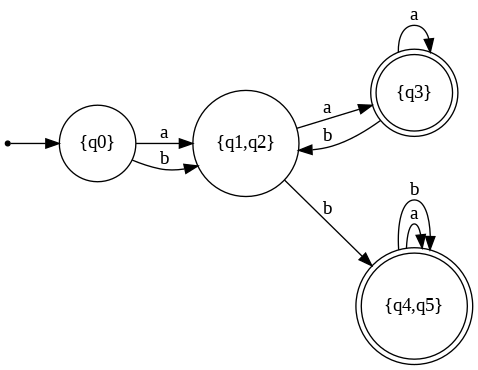

In [3]:
import graphviz
import os
from IPython.display import Image, display
class DFAState:
    def __init__(self, label, accept=False, merged_states=None):
        self.label = label
        self.accept = accept
        self.moves = {}
        self.merged_states = merged_states or {label}
def finding_unreachablestates(dfa, initial):
    live = set([initial])
    old_size = 0
    while len(live) > old_size:
        old_size = len(live)
        for state in list(live):
            for dest in dfa[state].moves.values():
                live.add(dest)
    return set(dfa.keys()) - live
def distinguishablestates(dfa, alphabet):
    size = len(dfa)
    states = list(dfa.keys())
    table = [[False] * size for _ in range(size)]
    for i in range(size):
        for j in range(i + 1, size):
            if dfa[states[i]].accept != dfa[states[j]].accept:
                table[i][j] = table[j][i] = True
    updated = True
    while updated:
        updated = False
        for i in range(size):
            for j in range(i + 1, size):
                if not table[i][j]:
                    for symbol in alphabet:
                        next_i = dfa[states[i]].moves.get(symbol)
                        next_j = dfa[states[j]].moves.get(symbol)
                        if bool(next_i) != bool(next_j):
                            table[i][j] = table[j][i] = True
                            updated = True
                            break
                        if next_i and next_j:
                            idx_i = states.index(next_i)
                            idx_j = states.index(next_j)
                            if table[idx_i][idx_j]:
                                table[i][j] = table[j][i] = True
                                updated = True
                                break
    return table
def minimize_dfa(dfa, alphabet, initial):
    dead = finding_unreachablestates(dfa, initial)
    for state in dead:
        del dfa[state]
    table = distinguishablestates(dfa, alphabet)
    states = list(dfa.keys())
    groups = []
    processed = set()
    for i in range(len(states)):
        if states[i] not in processed:
            group = {states[i]}
            for j in range(i + 1, len(states)):
                if not table[i][j] and states[j] not in processed:
                    group.add(states[j])
            groups.append(group)
            processed.update(group)
    reduced = {}
    group_map = {}
    for idx, group in enumerate(groups):
        sorted_states = sorted(list(group))
        new_name = f"q{idx}"
        group_map[frozenset(group)] = new_name
        is_accept = any(dfa[state].accept for state in group)
        reduced[new_name] = DFAState(new_name, is_accept, group)
    for group in groups:
        curr_name = group_map[frozenset(group)]
        rep = next(iter(group))
        for symbol in alphabet:
            if symbol in dfa[rep].moves:
                next_state = dfa[rep].moves[symbol]
                for target in groups:
                    if next_state in target:
                        reduced[curr_name].moves[symbol] = group_map[frozenset(target)]
                        break
    new_initial = None
    for group in groups:
        if initial in group:
            new_initial = group_map[frozenset(group)]
            break
    return reduced, new_initial
def create_graph(dfa, alphabet, initial):
    graph = graphviz.Digraph(format='png', engine='dot')
    graph.attr(rankdir='LR')
    graph.node('start', shape='point')
    graph.edge('start', initial)
    for name, state in dfa.items():
        label = "{" + ",".join(sorted(state.merged_states)) + "}"
        shape = 'doublecircle' if state.accept else 'circle'
        graph.node(name, label, shape=shape)
        for symbol, dest in state.moves.items():
            graph.edge(name, dest, label=symbol)
    return graph
def main():
    n = int(input("Enter the number of states in the DFA: "))
    dfa = {}
    for i in range(n):
        label = input(f"State {i + 1}: ")
        dfa[label] = DFAState(label)
    m = int(input("Enter the number of symbols in the alphabet: "))
    alphabet = [input(f"Symbol {i + 1}: ") for i in range(m)]
    print("\nEnter transitions for each state and symbol (use hyphen for no transition):")
    for label in dfa:
        for symbol in alphabet:
            dest = input(f"State {label}, Symbol {symbol}: ")
            if dest != "-":
                dfa[label].moves[symbol] = dest
    initial = input("\nEnter the start state: ")
    f = int(input("Enter the number of final states: "))
    for _ in range(f):
        accept = input("Enter final state: ")
        if accept in dfa:
            dfa[accept].accept = True
    reduced, new_initial = minimize_dfa(dfa, alphabet, initial)
    print("\nMinimized DFA:")
    print("States:", ["{" + ",".join(sorted(state.merged_states)) + "}" for state in reduced.values()])
    print("Start state:", "{" + ",".join(sorted(reduced[new_initial].merged_states)) + "}")
    print("Final states:", ["{" + ",".join(sorted(state.merged_states)) + "}" for state in reduced.values() if state.accept])
    print("\nTransitions:")
    for name, state in reduced.items():
        curr = "{" + ",".join(sorted(state.merged_states)) + "}"
        for symbol, dest in state.moves.items():
            dest_group = "{" + ",".join(sorted(reduced[dest].merged_states)) + "}"
            print(f"{curr} --{symbol}--> {dest_group}")
    os.makedirs('output', exist_ok=True)
    graph = create_graph(reduced, alphabet, new_initial)
    graph.render('output/minimized_dfa', format='png', cleanup=True)
    display(Image(filename='output/minimized_dfa.png'))
if __name__ == "__main__":
    main()